In [102]:
import numpy as np
import random
import datetime
import time
import os
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import pandas as pd
import seaborn as sns

import argparse
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
plt.rcParams['font.size'] = 18
#plt.rcParams['font.family'] = "serif"
tdir = 'in'
major = 5.0
minor = 3.0
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor


from ember_utils import *
from ember_model import *
from ember_pjr_utils import *

In [ ]:
def get_weights(model, data, layer, device):
    
    
    model.eval()
    
    weights_ = []
    
    for sample in data:
        X_ = torch.from_numpy(sample).type(torch.FloatTensor)
        X_ = X_.reshape(1, -1).to(device)
        
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook
        
        
        if layer == 'fc2':
            model.fc2.register_forward_hook(get_activation(layer))
        elif layer == 'fc3':
            model.fc3.register_forward_hook(get_activation(layer))
        elif layer == 'fc4':
            model.fc4.register_forward_hook(get_activation(layer))
            
        output = model(X_)
        weights_.append(activation[layer].cpu().numpy()[0])
    
    return weights_


def get_anomalyScoresSamples(weight_data, raw_data, chooseSample = True):
    clf = IsolationForest(max_samples=len(weight_data))
    clf.fit(weight_data)
    scores_prediction = clf.decision_function(weight_data)
    y_pred = clf.predict(weight_data)


    anomalous_idx = np.where(y_pred == -1.0)
    similar_idx = np.where(y_pred == 1.0)

    print(f'anomaly-similar samples {len(anomalous_idx[0])} - {len(similar_idx[0])}')
    
    if chooseSample:
        raw_data = np.array(raw_data)
        anomaly_samples = raw_data[anomalous_idx]
        similar_samples = random.sample(list(raw_data[similar_idx]), len(anomaly_samples))

        mal_replay_samples = np.concatenate((np.array(anomaly_samples), np.array(similar_samples)))

        return mal_replay_samples, scores_prediction
    else:
        return scores_prediction


def get_anomalySamples(X_train, model, device):
    layer = 'fc4'
    wegt = get_weights(model, X_train, layer, device)
    mal_raw = X_train[np.where(Y_train == 1)]
    mal_weight = np.array(wegt)[np.where(Y_train == 1)]
    
    
    good_weight_samples = X_train[np.where(Y_train == 0)]
    mal_weight_samples = X_train[np.where(Y_train == 1)]
    
    replay_mal_samples, anomalyscores = get_anomalyScoresSamples(mal_weight,\
                                         mal_weight_samples, chooseSample = True)
    
    
    if len(good_weight_samples) < len(replay_mal_samples):
        replay_good_samples = good_weight_samples
    else:
        replay_good_samples = random.sample(list(good_weight_samples), len(replay_mal_samples))
    
    
    replay_samples = np.concatenate((np.array(replay_good_samples), np.array(replay_mal_samples)))
    labels_to_replay = np.concatenate((np.zeros(len(replay_good_samples)), np.ones(len(replay_mal_samples))))
    
    return replay_samples, labels_to_replay, anomalyscores



all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']

data_dir = '../../month_based_processing_with_family_labels/'



patience = 5
replay_type = 'pjr'



num_exps = 1 #args.num_exps
#task_month = args.task_month
num_epoch = 500 #args.num_epoch
batch_size = 6000 #args.batch_size
num_samples_per_malware_family = 500

exp_type = 'weights'

exp_seeds = [random.randint(1, 99999) for i in range(num_exps)]


expSaveDir = '../Weights_'
resSaveDir = './Weights_'
expSaveFile = '/Weights_replay_'


raw_anomalyScores_Dict = {}
weight_anomalyScores_Dict = {}


cnt =  1    
for exp in exp_seeds:
    start_time = time.time()
    use_cuda = True
    print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
    use_cuda = use_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    torch.manual_seed(exp)

    model = Ember_MLP_Net()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000001)
       
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    print(f'Model has {count_parameters(model)/1000000}m parameters')    
    criterion = nn.BCELoss()    

    
    
    stored_global_family_dict = defaultdict(list)
    
    standardization = StandardScaler()
    standard_scaler = None
    for task_month in range(len(all_task_months)):
                
        print(f'\n{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Round {cnt} ...')
        task_start = time.time()
        
        #task_month = task_month
        current_task = all_task_months[task_month]
        task_months = all_task_months[:task_month+1]
        print(f'Current Task {current_task} w/ {num_samples_per_malware_family} samples to Replay per Malware family.')


        model_save_dir = str(expSaveDir) + 'model_' +\
                    str(exp_type) + str(expSaveFile) +\
                    str(num_samples_per_malware_family) + '/' + str(current_task) + '/'
        create_parent_folder(model_save_dir)
        
        opt_save_path = str(expSaveDir) + 'optimizer_' +\
                    str(exp_type) + str(expSaveFile) +\
                    str(num_samples_per_malware_family) + '/' + str(current_task) + '/'
        create_parent_folder(opt_save_path)
        
        
        results_save_dir = str(resSaveDir) + 'results_' +\
                    str(exp_type) + str(expSaveFile) +\
                    str(num_samples_per_malware_family) + '/' 
        create_parent_folder(results_save_dir)

        
        X_train, Y_train, Y_train_family = get_family_labeled_month_data(data_dir, current_task)
        X_test, Y_test, Y_test_family = get_family_labeled_task_test_data(data_dir, task_months, mlp_net=True)
        
        
        if current_task != all_task_months[0]:
            X_train = np.concatenate((np.array(X_train), np.array(X_replay)))
            Y_train = np.concatenate((np.array(Y_train), np.array(Y_replay)))
        
        
        print(f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Standardizing ...')
        standard_scaler = standardization.partial_fit(X_train)

        X_train = standard_scaler.transform(X_train)
        X_test = standard_scaler.transform(X_test)

        X_train, Y_train = np.array(X_train, np.float32), np.array(Y_train, np.int32)
        X_test, Y_test = np.array(X_test, np.float32), np.array(Y_test, np.int32)        
        
        
        # to debug
        #X_train, Y_train, Y_train_family = X_train[:500], Y_train [:500], Y_train_family[:500]
        #X_test, Y_test, Y_test_family = X_test[:50], Y_test[:50], Y_test_family[:50]
        
        

#         if current_task == all_task_months[0]:
#             num_replay_samples = 0
#             stored_global_family_dict = make_family_based_dict(\
#                                        X_train, Y_train, Y_train_family,\
#                                        current_task, stored_global_family_dict)
#         else:
#             stored_global_family_dict = make_family_based_dict(X_train, Y_train, Y_train_family,\
#                                                                    current_task, stored_global_family_dict)
            
#             X_train, Y_train, stored_global_family_dict =\
#                 get_replay_samples_IFBased(stored_global_family_dict, num_samples_per_malware_family)
            
        print()
        print(f'X_train {X_train.shape} Y_train {Y_train.shape}')
        print()
        
        '''
        print(f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Standardizing ...')
        standard_scaler = standardization.partial_fit(X_train)

        X_train = standard_scaler.transform(X_train)
        X_test = standard_scaler.transform(X_test)

        X_train, Y_train = np.array(X_train, np.float32), np.array(Y_train, np.int32)
        X_test, Y_test = np.array(X_test, np.float32), np.array(Y_test, np.int32)        
        '''        
        
        print(f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Training ...')
        task_training_time, epoch_ran, training_loss, validation_loss  =\
                                training_early_stopping(model, model_save_dir, opt_save_path,\
                                X_train, Y_train, X_test, Y_test, patience,\
                                batch_size, device, optimizer, num_epoch,\
                                 criterion, replay_type, current_task, exp, earlystopping=True)
        
        
        
        model = Ember_MLP_Net()
        model = model.to(device)
        #load the best model for this task
        best_model_path = model_save_dir + os.listdir(model_save_dir)[0]
        print(f'loading best model {best_model_path}')
        model.load_state_dict(torch.load(best_model_path))
        
        
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000001)
        best_optimizer = opt_save_path + os.listdir(opt_save_path)[0]
        print(f'loading best optimizer {best_optimizer}')
        optimizer.load_state_dict(torch.load(best_optimizer))
        
        
        
        acc, rocauc = testing_aucscore(model, X_test, Y_test, batch_size, device)
        
        
        end_time = time.time()

        print(f'Elapsed time {(end_time - start_time)/60} mins.')    
        

        task_end = time.time()
        task_run_time = (task_end - task_start)/60
        
        
        print()
        X_replay, Y_replay, mal_weights_anomaly = get_anomalySamples(X_train, model, device)
        num_replay_samples = len(X_replay)
        
#         mal_raw = X_train[np.where(Y_train == 1)]
#         mal_raw_anomaly = get_anomalyScoresSamples(mal_raw,\
#                                          mal_raw, chooseSample = False)
    
        #raw_anomalyScores_Dict[str(current_task)] = mal_raw_anomaly
        weight_anomalyScores_Dict[str(current_task)] = mal_weights_anomaly
        print()
        
        
        results_f = open(os.path.join(results_save_dir + 'v1_weight_' + str(num_samples_per_malware_family) + '_results.txt'), 'a')
        result_string = '{}\t{}\t{}\t{}\t{}\t{}\t\n'.format(current_task,epoch_ran, task_training_time, acc, rocauc, num_replay_samples)
        results_f.write(result_string)
        results_f.flush()
        results_f.close()
        
    
    end_time = time.time()
    cnt += 1
    print(f'Elapsed time {(end_time - start_time)/60} mins.')
   


Torch 1.6.0 CUDA 10.2
Model has 3.132161m parameters

2023-01-19 02:34:38 Round 1 ...
Current Task 2018-01 w/ 500 samples to Replay per Malware family.
X_train (55722, 2381) Y_train (55722,) Y_tr_family (55722,)
X_test (6192, 2381) Y_test (6192,) Y_te_family (6192,)
2023-01-19 02:34:39 Standardizing ...


  0%|          | 0/9 [00:00<?, ?it/s]


X_train (55722, 2381) Y_train (55722,)

2023-01-19 02:34:42 Training ...
Epoch 1 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7172, Train Acc: 0.5262
Val Loss: 0.6819, Val Acc: 0.6292
Validation loss decreased (inf --> 0.681884).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_1.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6664, Train Acc: 0.6091
Val Loss: 0.6455, Val Acc: 0.6789
Validation loss decreased (0.681884 --> 0.645491).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_2.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6187, Train Acc: 0.6829
Val Loss: 0.5891, Val Acc: 0.7156
Validation loss decreased (0.645491 --> 0.589064).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_3.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5654, Train Acc: 0.7226
Val Loss: 0.5194, Val Acc: 0.7825
Validation loss decreased (0.589064 --> 0.519355).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_4.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5102, Train Acc: 0.7575
Val Loss: 0.4571, Val Acc: 0.7981
Validation loss decreased (0.519355 --> 0.457085).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_5.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_5.pt
Epoch 6 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4621, Train Acc: 0.7829
Val Loss: 0.4076, Val Acc: 0.8128
Validation loss decreased (0.457085 --> 0.407604).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_6.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_6.pt
Epoch 7 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4236, Train Acc: 0.8032
Val Loss: 0.3658, Val Acc: 0.8344
Validation loss decreased (0.407604 --> 0.365778).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_7.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_7.pt
Epoch 8 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3863, Train Acc: 0.8235
Val Loss: 0.3283, Val Acc: 0.8600
Validation loss decreased (0.365778 --> 0.328322).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_8.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_8.pt
Epoch 9 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3546, Train Acc: 0.8413
Val Loss: 0.2964, Val Acc: 0.8802
Validation loss decreased (0.328322 --> 0.296375).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_9.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_9.pt
Epoch 10 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3312, Train Acc: 0.8551
Val Loss: 0.2731, Val Acc: 0.8833
Validation loss decreased (0.296375 --> 0.273139).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_10.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_10.pt
Epoch 11 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3061, Train Acc: 0.8652
Val Loss: 0.2571, Val Acc: 0.8924
Validation loss decreased (0.273139 --> 0.257081).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_11.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_11.pt
Epoch 12 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2860, Train Acc: 0.8779
Val Loss: 0.2450, Val Acc: 0.8898
Validation loss decreased (0.257081 --> 0.244997).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_12.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_12.pt
Epoch 13 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2753, Train Acc: 0.8824
Val Loss: 0.2376, Val Acc: 0.8997
Validation loss decreased (0.244997 --> 0.237641).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_13.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_13.pt
Epoch 14 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2606, Train Acc: 0.8888
Val Loss: 0.2285, Val Acc: 0.8996
Validation loss decreased (0.237641 --> 0.228548).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_14.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_14.pt
Epoch 15 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2467, Train Acc: 0.8961
Val Loss: 0.2254, Val Acc: 0.9041
Validation loss decreased (0.228548 --> 0.225355).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_15.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_15.pt
Epoch 16 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2402, Train Acc: 0.8996
Val Loss: 0.2212, Val Acc: 0.9060
Validation loss decreased (0.225355 --> 0.221194).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_16.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_16.pt
Epoch 17 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2321, Train Acc: 0.9051
Val Loss: 0.2172, Val Acc: 0.9103
Validation loss decreased (0.221194 --> 0.217219).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_17.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_17.pt
Epoch 18 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2221, Train Acc: 0.9095
Val Loss: 0.2099, Val Acc: 0.9121
Validation loss decreased (0.217219 --> 0.209932).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_18.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_18.pt
Epoch 19 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2173, Train Acc: 0.9115
Val Loss: 0.2093, Val Acc: 0.9148
Validation loss decreased (0.209932 --> 0.209315).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_19.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_19.pt
Epoch 20 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2072, Train Acc: 0.9156
Val Loss: 0.2055, Val Acc: 0.9193
Validation loss decreased (0.209315 --> 0.205530).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_20.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_20.pt
Epoch 21 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2034, Train Acc: 0.9187
Val Loss: 0.2024, Val Acc: 0.9207
Validation loss decreased (0.205530 --> 0.202421).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_21.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_21.pt
Epoch 22 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1992, Train Acc: 0.9207
Val Loss: 0.2018, Val Acc: 0.9204
Validation loss decreased (0.202421 --> 0.201778).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_22.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_22.pt
Epoch 23 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1920, Train Acc: 0.9231
Val Loss: 0.1984, Val Acc: 0.9214
Validation loss decreased (0.201778 --> 0.198449).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_23.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_23.pt
Epoch 24 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1920, Train Acc: 0.9232
Val Loss: 0.1959, Val Acc: 0.9198
Validation loss decreased (0.198449 --> 0.195865).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_24.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_24.pt
Epoch 25 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1895, Train Acc: 0.9239
Val Loss: 0.1980, Val Acc: 0.9122
EarlyStopping counter: 1 out of 5
Epoch 26 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1828, Train Acc: 0.9280
Val Loss: 0.1967, Val Acc: 0.9130
EarlyStopping counter: 2 out of 5
Epoch 27 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1765, Train Acc: 0.9305
Val Loss: 0.1906, Val Acc: 0.9223
Validation loss decreased (0.195865 --> 0.190605).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_27.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_27.pt
Epoch 28 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1731, Train Acc: 0.9313
Val Loss: 0.1902, Val Acc: 0.9177
Validation loss decreased (0.190605 --> 0.190150).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_28.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_28.pt
Epoch 29 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1711, Train Acc: 0.9322
Val Loss: 0.1895, Val Acc: 0.9185
Validation loss decreased (0.190150 --> 0.189490).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_29.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_29.pt
Epoch 30 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1710, Train Acc: 0.9314
Val Loss: 0.1889, Val Acc: 0.9180
Validation loss decreased (0.189490 --> 0.188888).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_30.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_30.pt
Epoch 31 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1677, Train Acc: 0.9343
Val Loss: 0.1838, Val Acc: 0.9246
Validation loss decreased (0.188888 --> 0.183821).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_31.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_31.pt
Epoch 32 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1603, Train Acc: 0.9366
Val Loss: 0.1872, Val Acc: 0.9211
EarlyStopping counter: 1 out of 5
Epoch 33 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1606, Train Acc: 0.9362
Val Loss: 0.1860, Val Acc: 0.9261
EarlyStopping counter: 2 out of 5
Epoch 34 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1555, Train Acc: 0.9386
Val Loss: 0.1849, Val Acc: 0.9278
EarlyStopping counter: 3 out of 5
Epoch 35 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1560, Train Acc: 0.9385
Val Loss: 0.1799, Val Acc: 0.9279
Validation loss decreased (0.183821 --> 0.179870).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_35.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_35.pt
Epoch 36 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1529, Train Acc: 0.9391
Val Loss: 0.1819, Val Acc: 0.9231
EarlyStopping counter: 1 out of 5
Epoch 37 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1519, Train Acc: 0.9397
Val Loss: 0.1798, Val Acc: 0.9231
Validation loss decreased (0.179870 --> 0.179799).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_37.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_37.pt
Epoch 38 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1489, Train Acc: 0.9414
Val Loss: 0.1758, Val Acc: 0.9308
Validation loss decreased (0.179799 --> 0.175781).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_38.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_38.pt
Epoch 39 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1472, Train Acc: 0.9442
Val Loss: 0.1751, Val Acc: 0.9285
Validation loss decreased (0.175781 --> 0.175075).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_39.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_39.pt
Epoch 40 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1418, Train Acc: 0.9444
Val Loss: 0.1778, Val Acc: 0.9282
EarlyStopping counter: 1 out of 5
Epoch 41 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1418, Train Acc: 0.9451
Val Loss: 0.1793, Val Acc: 0.9257
EarlyStopping counter: 2 out of 5
Epoch 42 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1416, Train Acc: 0.9449
Val Loss: 0.1722, Val Acc: 0.9315
Validation loss decreased (0.175075 --> 0.172201).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_42.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_42.pt
Epoch 43 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1394, Train Acc: 0.9462
Val Loss: 0.1759, Val Acc: 0.9215
EarlyStopping counter: 1 out of 5
Epoch 44 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1362, Train Acc: 0.9464
Val Loss: 0.1764, Val Acc: 0.9289
EarlyStopping counter: 2 out of 5
Epoch 45 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1349, Train Acc: 0.9478
Val Loss: 0.1748, Val Acc: 0.9271
EarlyStopping counter: 3 out of 5
Epoch 46 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1315, Train Acc: 0.9493
Val Loss: 0.1668, Val Acc: 0.9325
Validation loss decreased (0.172201 --> 0.166823).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_46.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_46.pt
Epoch 47 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1316, Train Acc: 0.9488
Val Loss: 0.1736, Val Acc: 0.9248
EarlyStopping counter: 1 out of 5
Epoch 48 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1314, Train Acc: 0.9484
Val Loss: 0.1709, Val Acc: 0.9272
EarlyStopping counter: 2 out of 5
Epoch 49 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1285, Train Acc: 0.9499
Val Loss: 0.1681, Val Acc: 0.9301
EarlyStopping counter: 3 out of 5
Epoch 50 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1279, Train Acc: 0.9510
Val Loss: 0.1705, Val Acc: 0.9299
EarlyStopping counter: 4 out of 5
Epoch 51 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1260, Train Acc: 0.9516
Val Loss: 0.1641, Val Acc: 0.9336
Validation loss decreased (0.166823 --> 0.164099).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_51.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_51.pt
Epoch 52 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1256, Train Acc: 0.9508
Val Loss: 0.1618, Val Acc: 0.9360
Validation loss decreased (0.164099 --> 0.161753).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_52.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_52.pt
Epoch 53 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1230, Train Acc: 0.9517
Val Loss: 0.1676, Val Acc: 0.9332
EarlyStopping counter: 1 out of 5
Epoch 54 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1207, Train Acc: 0.9528
Val Loss: 0.1612, Val Acc: 0.9364
Validation loss decreased (0.161753 --> 0.161192).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_54.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_54.pt
Epoch 55 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1169, Train Acc: 0.9539
Val Loss: 0.1592, Val Acc: 0.9368
Validation loss decreased (0.161192 --> 0.159186).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_55.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_55.pt
Epoch 56 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1176, Train Acc: 0.9549
Val Loss: 0.1623, Val Acc: 0.9342
EarlyStopping counter: 1 out of 5
Epoch 57 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1144, Train Acc: 0.9559
Val Loss: 0.1590, Val Acc: 0.9292
Validation loss decreased (0.159186 --> 0.158984).  Saving model ...
../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_57.pt
../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_57.pt
Epoch 58 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1140, Train Acc: 0.9564
Val Loss: 0.1611, Val Acc: 0.9352
EarlyStopping counter: 1 out of 5
Epoch 59 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1156, Train Acc: 0.9549
Val Loss: 0.1631, Val Acc: 0.9381
EarlyStopping counter: 2 out of 5
Epoch 60 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1085, Train Acc: 0.9587
Val Loss: 0.1664, Val Acc: 0.9367
EarlyStopping counter: 3 out of 5
Epoch 61 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1104, Train Acc: 0.9573
Val Loss: 0.1645, Val Acc: 0.9401
EarlyStopping counter: 4 out of 5
Epoch 62 of 500


  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1098, Train Acc: 0.9588
Val Loss: 0.1666, Val Acc: 0.9324
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.963 minutes
loading best model ../Weights_model_weights/Weights_replay_500/2018-01/best_model_epoch_57.pt
loading best optimizer ../Weights_optimizer_weights/Weights_replay_500/2018-01/best_optimizer_epoch_57.pt


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


test accuracy 0.9334583580493927 and ROC-AUC 0.9396782327010419
Elapsed time 2.0444429755210876 mins.



In [74]:
def get_weights(model, data, layer, device):
    
    
    model.eval()
    
    weights_ = []
    
    for sample in data:
        X_ = torch.from_numpy(sample).type(torch.FloatTensor)
        X_ = X_.reshape(1, -1).to(device)
        
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook
        
        
        if layer == 'fc2':
            model.fc2.register_forward_hook(get_activation(layer))
        elif layer == 'fc3':
            model.fc3.register_forward_hook(get_activation(layer))
        elif layer == 'fc4':
            model.fc4.register_forward_hook(get_activation(layer))
            
        output = model(X_)
        weights_.append(activation[layer].cpu().numpy()[0])
    
    return weights_


layer = 'fc4'
wegt = get_weights(model, X_train, layer, device)

In [80]:
#len(wegt) == len(X_train), 
#Y_train[np.where(Y_train == 1)]

mal_raw = X_train[np.where(Y_train == 1)]
mal_wegt = np.array(wegt)[np.where(Y_train == 1)]

In [81]:
len(mal_raw), len(mal_wegt)

(29309, 29309)

In [88]:
def get_anomalyScoresSamples(weight_data, raw_data, chooseSample = True):
    clf = IsolationForest(max_samples=len(weight_data))
    clf.fit(weight_data)
    scores_prediction = clf.decision_function(weight_data)
    y_pred = clf.predict(weight_data)


    anomalous_idx = np.where(y_pred == -1.0)
    similar_idx = np.where(y_pred == 1.0)

    print(f'anomaly-similar samples {len(anomalous_idx[0])} - {len(similar_idx[0])}')
    
    if chooseSample:
        raw_data = np.array(raw_data)
        anomaly_samples = raw_data[anomalous_idx]
        similar_samples = random.sample(list(raw_data[similar_idx]), len(anomaly_samples))

        mal_replay_samples = np.concatenate((np.array(anomaly_samples), np.array(similar_samples)))

        return mal_replay_samples, scores_prediction
    else:
        return mal_replay_samples, scores_prediction


def get_anomalySamples(X_train, model, device):
    layer = 'fc4'
    wegt = get_weights(model, X_train, layer, device)
    mal_raw = X_train[np.where(Y_train == 1)]
    mal_weight = np.array(wegt)[np.where(Y_train == 1)]
    
    
    good_weight_samples = X_train[np.where(Y_train == 0)]
    mal_weight_samples = X_train[np.where(Y_train == 1)]
    
    replay_mal_samples, anomalyscores = get_anomalyScoresSamples(mal_weight,\
                                         mal_weight_samples, chooseSample = True)
    
    
    if len(good_weight_samples) < len(replay_mal_samples):
        replay_good_samples = good_weight_samples
    else:
        replay_good_samples = random.sample(list(good_weight_samples), len(replay_mal_samples))
    
    
    replay_samples = np.concatenate((np.array(replay_good_samples), np.array(replay_mal_samples)))
    labels_to_replay = np.concatenate((np.zeros(len(replay_good_samples)), np.ones(len(replay_mal_samples))))
    
    return replay_samples, labels_to_replay, anomalyscores




In [96]:
len(np.array(wegt)[np.where(Y_train_family == 'tinba')]), len(np.where(Y_train_family == 'tinba')[0])

(190, 190)

In [ ]:
for fam_ind, fam_label in enumerate(Y_train_family):
    if Y_train[fam_ind] != 0:
        

In [87]:
len(Y_train_family)

55722

In [ ]:
def make_family_based_dict(X_train, Y_train, Y_train_family, task_month, global_family_dict):
    count = 0
    for x_ind, x_sample in enumerate(X_train):
        count += 1
        #print(x_ind, Y_train[x_ind])

        if Y_train[x_ind] == 0:
            global_family_dict["goodware"].append(x_sample)
        if Y_train[x_ind] == 1:
            if Y_train_family[x_ind] == '':
                global_family_dict["others_family"].append(x_sample)
            else:
                global_family_dict[Y_train_family[x_ind]].append(x_sample)

    print(f'Task {task_month} and #-of new samples stored {count}')
    
    return global_family_dict

In [68]:
from sklearn.ensemble import IsolationForest

In [82]:
def get_anomalyScores(data):
    clf = IsolationForest(max_samples=len(data))
    clf.fit(data)
    scores_prediction = clf.decision_function(data)
    y_pred = clf.predict(data)


    anomalous_idx = np.where(y_pred == -1.0)
    similar_idx = np.where(y_pred == 1.0)

    print(f'anomaly-similar samples {len(anomalous_idx[0])} - {len(similar_idx[0])}')
    
    return scores_prediction


raw_anomaly = get_anomalyScores(mal_raw)
hidden_anomaly = get_anomalyScores(mal_wegt)

anomaly-similar samples 8 - 29301
anomaly-similar samples 327 - 28982


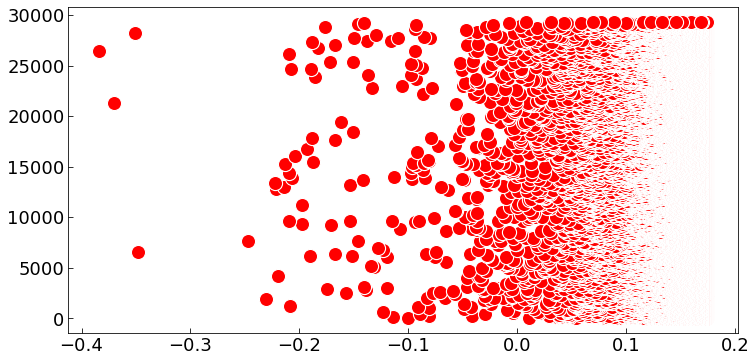

In [86]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=hidden_anomaly, y=[i for i in range(len(hidden_anomaly))], color='red',
                 marker='o', s=200,  alpha=1.0)


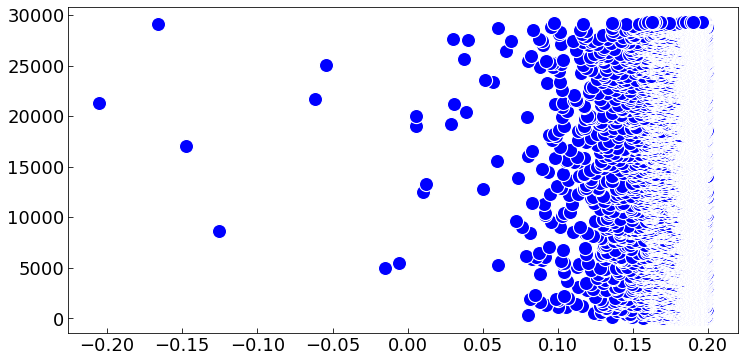

In [83]:
plt.figure(figsize=(12, 6))

sns.scatterplot(x=raw_anomaly, y=[i for i in range(len(raw_anomaly))], color='blue',
                 marker='o', s=200,  alpha=1.0)


In [59]:
X_partial = torch.from_numpy(X_test[0]).type(torch.FloatTensor)
X_partial = X_partial.reshape(1, -1).to(device)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
X__ = torch.randn(1, 2381).to(device)

#print(model)

model.fc4.register_forward_hook(get_activation('fc4'))
output = model(X_partial)
activation['fc4']



tensor([[-0.9141,  0.5025,  0.4549, -0.2445, -0.5742,  0.5611,  0.3200,  0.2804,
         -0.0201,  0.7599,  0.0185, -0.7983,  0.1927, -0.5078, -0.4734,  0.4082,
          0.2988,  0.6552, -0.7080,  0.6065, -0.3862,  0.5355,  0.1356, -0.5825,
          0.6145,  0.1265, -0.7096,  0.4439,  0.4675,  0.4716,  0.3591,  0.6058,
         -0.3708, -1.2019, -0.7278,  0.5031,  0.6456,  0.8547,  0.3175,  0.5376,
          0.1578,  0.6338, -0.7163,  0.3647,  0.6368, -0.4985,  0.4210,  0.4145,
         -0.0817, -0.6840, -0.6164, -0.7414,  0.1943,  0.5484,  0.0496, -0.3584,
         -0.9522, -0.3232,  0.4768,  0.3057,  0.3553,  0.4393, -0.4086,  0.7328,
         -0.2180, -0.8600,  0.6451, -1.0335,  0.1668,  0.0864, -0.7120,  0.6086,
         -0.4466,  0.2163,  0.6120, -0.3605,  0.6569, -0.5985,  0.6693,  0.2626,
         -0.4405, -0.1760, -0.4872,  0.1403, -0.6262, -0.9400,  0.1485,  0.3536,
         -0.5842, -0.2083, -0.7032, -0.5963,  0.1501, -0.4507,  0.1778,  0.5751,
         -0.5583, -0.4706, -

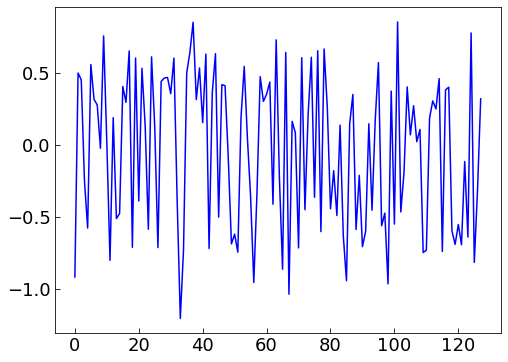

In [50]:

plt.figure(figsize=(8, 6))
plt.plot(fc4weights[0], color='b');

In [37]:
len(fc4weights[0])

128

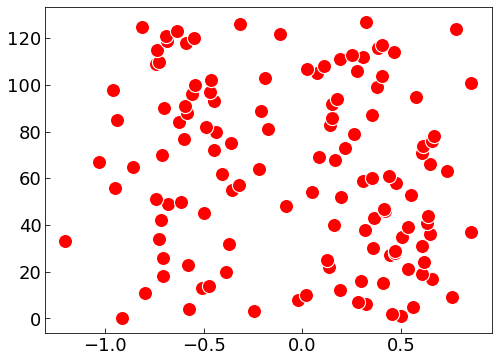

In [47]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x=fc4weights[0], y=[i for i in range(len(fc4weights[0]))], color='red',
                 marker='o', s=200,  alpha=1.0)
